# Coherent OFDM Fiber Optical Transmission System 

#### PAPR SLM and Clipping techniques

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import special
from scipy.signal import spectrogram
from scipy.signal import welch
import math
import os
import time

from commpy.utilities import upsample
from optic.dsp.core import pnorm, pulseShape, signal_power, movingAverage
from optic.dsp.carrierRecovery import cpr
from optic.models.devices import iqm, phaseNoise, coherentReceiver, edfa, basicLaserModel
from optic.models.channels import ssfm, manakovSSF, awgn
from optic.comm.modulation import GrayMapping, modulateGray
from optic.utils import parameters
from optic.plot import plotPSD, pconst
from optic.comm.ofdm  import modulateOFDM, demodulateOFDM
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM

%matplotlib inline
import mpld3

from heapq import nsmallest
import cmath

**OFDM parameters**

---



In [2]:
MAX_SAMPLES = 100000
K = 1024 # number of OFDM subcarriers
mu = 4 # bits per symbol (i.e. 16QAM) 
# CP = K//4  # length of the cyclic prefix: 25% of the block
CP = 128
filename_raw_bits = 'raw_bit_sequence_training.npy'

dataCarriers = np.zeros((K), dtype=complex)


plotting the 16QAM constellation, along with the bit-labels. Note the Gray-mapping, i.e. two adjacent constellation symbols differ only by one bit and the other 3 bits remain the same. This technique helps to minimize bit-errors, in case a wrong constellation symbol is detected: Most probably, symbol errors are "off-by-one" errors, i.e. a symbol next to the correct symbol is detected. Then, only a single bit-error occurs.


**Functions**


---



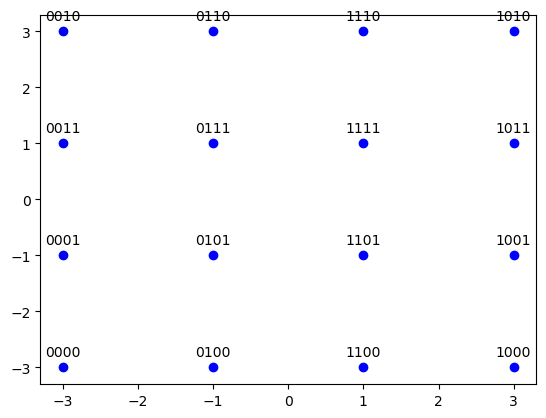

In [3]:
# QAM Mapping Table

mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

# The demapping table is simply the inverse mapping of the mapping table:

# %%
demapping_table = {v : k for k, v in mapping_table.items()}

# function definitions
def SP(bits):
    return bits.reshape((payloadBits_per_OFDM//mu, mu))

def Mapping(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[0] = 40 + 1j*40 # allocate the RF pilot subcarriers 
    symbol[11+10:449] = QAM_payload[0:438-10]  # allocate the Data1 subcarriers
    symbol[577:1014-10] = QAM_payload[438-10:875-20]  # allocate the Data2 subcarriers
    return symbol

def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data, K)

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples ...
    return np.hstack([cp, OFDM_time])  # ... and add them to the beginning

def SpectPlot(SigTime):
    f, psd = welch(SigTime, 20, return_onesided=False, nperseg=1024)
    # Plot the PSD
    plt.plot(f, 10*np.log10(psd))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    plt.show()

def MagniPlot(SigTime):
    ofdm_spectrum = 10*np.log10(np.fft.fftshift(np.fft.fft(SigTime[0:1023])))
    # Plot the signal spectrum
    plt.plot(ofdm_spectrum)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX, K)

def OFDM_symbol_Rx(QAM_rx):
    QAM_payload_rx = []
    # QAM_payload_rx[0:437] = QAM_rx[11:448]
    # QAM_payload_rx[438:875] = QAM_rx[577:1014]
    QAM_payload_rx = np.append(QAM_payload_rx, QAM_rx[11+10:449])
    QAM_payload_rx = np.append(QAM_payload_rx, QAM_rx[577:1014-10])
    return QAM_payload_rx

def Demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1,1)) - constellation.reshape((1,-1)))
    
    # for each element in QAM, choose the index in constellation 
    # that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into the bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

def rfp(OFDM_freq_domain, OFDM_time_domain):
    # Filter out RF + guide band
    OFDM_freq_domain[11+10:1014-10] = 0

    # Convert back to time domain
    OFDM_ifft_freq = np.fft.ifft(OFDM_freq_domain)

    # Extract the phase
    phase_exp = OFDM_ifft_freq/np.abs(OFDM_ifft_freq)

    # compensation in time domain 
    OFDM_time_domain_comp = OFDM_time_domain*np.conj(phase_exp)

    return np.fft.fft(OFDM_time_domain_comp)

def removeCP(signal):
    return signal[CP:(CP+K)]

def PS(bits):
    return bits.reshape((-1,))


# Plot functions
labelTextSize = 14

def plotBER(BERSets, xval, xlabel, title=None, legend=None, semilog=True, show=True, savePath=None):

    plt.figure(figsize=(16,9))
    for BER in BERSets:
        if semilog:
            BER = np.array(BER)
            BER[BER<1e-3] = -1
            plt.semilogy(xval, BER, '-o', nonposy='mask')
        else:
            plt.plot(xval, BER, '-o')

    plt.tick_params(labelsize=labelTextSize)
    plt.xlabel(xlabel, fontsize=labelTextSize)
    plt.ylabel('BER', fontsize=labelTextSize)
    plt.ylim([0,1.0])
    plt.grid()

    if title is not None:
        plt.title(title, fontsize=labelTextSize)
    else:
        plt.title("Bit Error Rates", fontsize=labelTextSize)

    if legend is not None:
        plt.legend(legend, fontsize=labelTextSize)
    if savePath is not None:
        plt.savefig(savePath, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()


def plotCCDF(paprDbSet, steps=0.1, title=None, legend=None,  show=True, savePath=None):

    if not isinstance(paprDbSet, list):
        paprDbList = [paprDbSet]
    else:
        paprDbList = paprDbSet

    plt.figure(figsize=(16, 9))

    # plotting for all sets of paprDb vals provided
    for paprDb in paprDbList:
        valRange = np.arange(np.min(paprDb), np.max(paprDb), steps)
        y = np.zeros(valRange.shape)
        for vdx, val in enumerate(valRange):
            # calculating probability of papr > val
            y[vdx] = (len(paprDb[paprDb > val]) / (1.0 * len(paprDb)))

        # adding to plot
        plt.plot(valRange, y, '-o')

    plt.tick_params(labelsize=labelTextSize)
    plt.xlabel('Z (dB)', fontsize=labelTextSize)
    plt.ylabel('Prob (PAPR > Z)', fontsize=labelTextSize)
    plt.grid()

    if title is not None:
        plt.title(title, fontsize=labelTextSize)
    else:
        plt.title("CCDF for PAPR", fontsize=labelTextSize)

    if legend is not None:
        plt.legend(legend, fontsize=labelTextSize)
    if savePath is not None:
        plt.savefig(savePath, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()
    return y, valRange

def polar2rect(r, phi):
    phi = cmath.pi * phi / 180.0
    return cmath.rect(r,phi)

def clipOFDM(ofdmChunks, clippingPercent):
    clippingVal = clippingPercent  * np.max(np.abs(ofdmChunks))
    ofdmChunks_clip = np.zeros(K+CP, dtype=complex)
    for cdx, val in enumerate(ofdmChunks):
        if np.abs(val) > clippingVal:
            # clipping magnitude, phase same as before
            ofdmChunks_clip[cdx] = polar2rect(clippingVal, np.angle(val, deg=True))
        else:
            ofdmChunks_clip[cdx] = ofdmChunks[cdx]
    
    return ofdmChunks_clip

# to be applied before iFFT
# configurable --> phaseCandidates = [0, 8, 16, 32, 64]
SLMCandidates = 64
# hard coded, to be checked why
SLMPhaseRotationOptions = [1, -1, 1j, -1j]

def applySLM(ofdmChunks):
    np.random.seed(self.seed)
    SLMPhaseVectorIdx  = np.zeros(ofdmChunks.shape[0])
    phaseVecCandidates = np.random.choice(SLMPhaseRotationOptions, (SLMCandidates, len(ofdmChunks))) 

    slmChunks = np.zeros_like(ofdmChunks)
    for cdx, chunk in enumerate(ofdmChunks):

        # multiplying by each phaseVec candidate and finding min obtained papr
        minPAPR = np.inf
        minPdx = None
        for pdx, phaseVec in enumerate(phaseVecCandidates):
            mapped = np.multiply(chunk, phaseVec)
            mappedTimeDomainSq = np.power(np.abs(np.fft.ifft(mapped, self.N, axis=-1)),2) 
            PAPR = np.divide(np.max(mappedTimeDomainSq), np.mean(mappedTimeDomainSq)) 
            if PAPR < minPAPR:
                minPAPR = PAPR
                minPdx = pdx

        # storing mapped vec with min papr
        slmChunks[cdx] = np.multiply(chunk, phaseVecCandidates[minPdx])
        self.SLMPhaseVectorIdx [cdx] = minPdx

    return slmChunks

def unmapSLM(modSymbols):

        if self.SLMPhaseVectorIdx is None:
            raise Exception("phase vector indexes use for slm not provided")
        elif self.SLMPhaseVectorIdx.shape[0] != modSymbols.shape[0]:
            raise Exception("number of phase vector indexes not the same as number of symbols received")

        np.random.seed(self.seed)
        phaseVecCandidates = np.random.choice(self.SLMPhaseRotationOptions, (self.SLMCandidates, self.N)) 
        
        unmappedSymbols = np.zeros_like(modSymbols)
        for sdx, (pdx, sym) in enumerate(zip(self.SLMPhaseVectorIdx, modSymbols)):
            unmappedSymbols[sdx] = np.multiply(np.conj(phaseVecCandidates[int(pdx)]), sym)   # multiplying by complex conjugate of phase vector 

        return unmappedSymbols

**Transmitter** **Section**


---



In [4]:
# load bits from file
totalbits = np.load('raw_bit_sequence_training.npy')

# number of QAM samples min (MAX_SAMPLES, 2,560,000) 
number_of_samples = min(MAX_SAMPLES, len(totalbits) // mu)
print("Expected number of samples generated from raw bits: " + str(number_of_samples))
my_range = range(number_of_samples)
print(my_range)

Expected number of samples generated from raw bits: 100000
range(0, 100000)


OFDM TX sizer =  131328


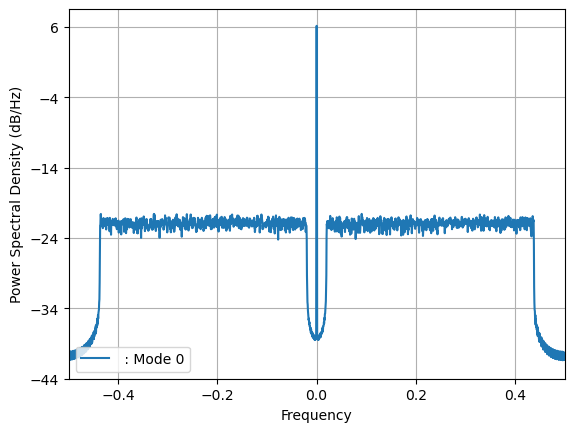

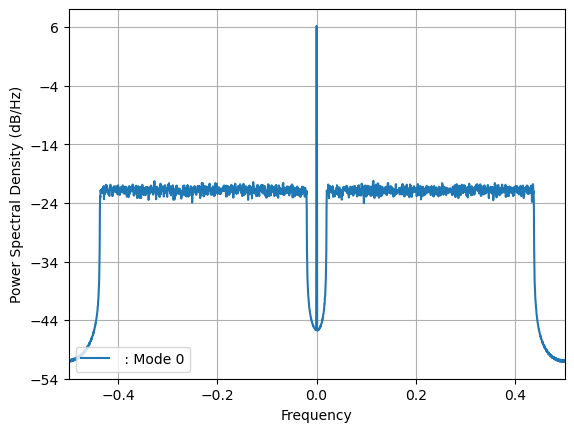

C:\app\tools\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


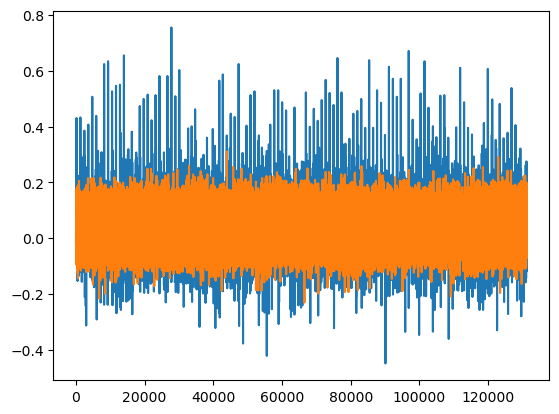

In [5]:
# %% Zero Padding = 128 + guard band RF pilot 20 + RFP = 1
# Total QAM symbols is 875 positive side 438, negative side 437, 
# OFDM symbol = 1 0 0 0..(10).. 0 0 0 data1(438) 0 0 0 0 0 0..(128).. 0 0 0 0 0 data2(437) 0 0 0 0 0 ..(10).....
import sys
clip = False
clippingPercent = 0.75
slm = True
PAPRnet = False

payloadBits_per_OFDM = K*mu - 128*mu - 41*mu  # number of payload bits per OFDM symbol
payloadSymbols_per_OFDM = payloadBits_per_OFDM//mu

# calculation how many OFDM symbols will be sent --> 114
number_of_OFDM_Symbols = (number_of_samples)//payloadSymbols_per_OFDM

# working with each OFDM symbol
OFDM_data_all = []
OFDM_tx = []
OFDM_tx_clip = []
OFDM_tx_slm = []
OFDM_tx_NN = []
PAPR_org = []
PAPR_clip = []
PAPR_slm = []
PAPR_NN = []

bits_used = []

# SLM parameters
OFDM_data_slm = []
SLMPhaseVectors = np.zeros( ((number_of_OFDM_Symbols-2), K), dtype=complex )
SLMCandidates = 64
SLMPhaseRotationOptions = [1, -1, 1j, -1j]
seed = 2727
np.random.seed(seed)

# NN settings 
if PAPRnet:
    # Encoding
    encoder = PAPRnetEncoder(855)
    encoder.load_weights('encoder.hdf5')
    # Decoding
    decoder = PAPRnetDecoder(855)
    decoder.load_weights('decoder.hdf5')
    

for i in range(number_of_OFDM_Symbols-2):
    # prepare the required bits for one OFDM symbol
    bits = totalbits[0+payloadBits_per_OFDM*i:payloadBits_per_OFDM+payloadBits_per_OFDM*i]
    bits_SP = SP(bits)
    
    # 16-QAM mapping
    QAM = Mapping(bits_SP)
    
    # prepare OFDM symbol
    OFDM_data = OFDM_symbol(QAM)
    
    # collecting OFDM data for NN
    OFDM_data_all = np.append(OFDM_data_all, QAM)
    
    if slm:
        # SLMP hase Candidates
        phaseVecCandidates = np.random.choice(SLMPhaseRotationOptions, (SLMCandidates, len(OFDM_data))) 

        # multiplying by each phaseVec candidate and finding min obtained papr
        minPAPR = 0
        minPdx = None
        for pdx, phaseVec in enumerate(phaseVecCandidates):
            mapped = np.multiply(OFDM_data, phaseVec)
            mappedTimeDomainSq = np.power(np.abs(np.fft.ifft(mapped, len(OFDM_data), axis=-1)),2) 
            PAPR = np.divide(np.max(mappedTimeDomainSq), np.mean(mappedTimeDomainSq)) 
            if PAPR > minPAPR:
                minPAPR = PAPR
                minPdx = pdx
        # storing mapped vec with min papr
        OFDM_data_slm = np.multiply(OFDM_data, phaseVecCandidates[minPdx])
        SLMPhaseVectors[i] = phaseVecCandidates[minPdx]
        
        # adding RF pilot with Guide band
        OFDM_data_slm[0] = 40 + 1j*40 # allocate the RF pilot subcarriers 
        
        # transmitter parts for slm 
        OFDM_time_slm = IDFT(OFDM_data_slm)     
        OFDM_withCP_slm = addCP(OFDM_time_slm)
        
        # compute the PAPR of the time-domain signal sample
        power_peak_slm = max(np.square(abs(OFDM_withCP_slm)))
        power_mean_slm = np.mean(np.square(abs(OFDM_withCP_slm)), dtype=np.float64)

        # decibel above average power
        PAPR_value_slm = 10* np.log10(power_peak_slm / power_mean_slm)

        PAPR_slm = np.append(PAPR_slm, PAPR_value_slm)
        
        # collecting the OFDM Frame
        OFDM_tx_slm = np.append(OFDM_tx_slm, OFDM_withCP_slm)
    

    # converting to time domain
    OFDM_time = IDFT(OFDM_data)

    # adding CP
    OFDM_withCP = addCP(OFDM_time)
    
    # compute the PAPR of the time-domain signal sample
    power_peak = max(np.square(abs(OFDM_withCP)))
    power_mean = np.mean(np.square(abs(OFDM_withCP)), dtype=np.float64)

    # decibel above average power
    PAPR_value = 10* np.log10(power_peak / power_mean)
    
    PAPR_org = np.append(PAPR_org, PAPR_value)
    
    if clip:
        OFDM_withCP_clip = clipOFDM(OFDM_withCP, clippingPercent)
        
        # compute the PAPR of the time-domain signal sample
        power_peak_clip = max(np.square(abs(OFDM_withCP_clip)))
        power_mean_clip = np.mean(np.square(abs(OFDM_withCP_clip)), dtype=np.float64)

        # decibel above average power
        PAPR_value_clip = 10* np.log10(power_peak_clip / power_mean_clip)

        PAPR_clip = np.append(PAPR_clip, PAPR_value_clip)
        
        OFDM_tx_clip = np.append(OFDM_tx_clip, OFDM_withCP_clip)
    
    # collecting the OFDM Frame
    OFDM_tx = np.append(OFDM_tx, OFDM_withCP)
    
    # collecting bit steam for BER calculation
    bits_used = np.append(bits_used, bits)

    
if PAPRnet:
    # reshape to matrix 
    OFDM_data_input = OFDM_data_all.reshape((-1,855))
    
    # splitting real and imaginary comp
    OFDM_data_Rect = np.concatenate( [np.expand_dims(OFDM_data_input.real, 1),np.expand_dims(OFDM_data_input.imag, 1)], axis=1)

    # getting encoder output
    OFDM_data_NN_Rec = encoder.predict(OFDM_data_Rect, batch_size=855)   

    # converting to complex value (a+bj)
    ofdm_data_NN = OFDM_data_NN_Rec[:, 0, :] + 1j * OFDM_data_NN_Rec[:, 1, :]

    # OFDM data preparing
    
    for idx, OfdmVec in enumerate(ofdm_data_NN):
        symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
        symbol[0] = 40 + 1j*40 # allocate the RF pilot subcarriers 
        symbol[11+10:449] = OfdmVec[0:438-10]  # allocate the Data1 subcarriers
        symbol[577:1014-10] = OfdmVec[438-10:875-20]  # allocate the Data2 subcarriers
        
        # IFFT
        OFDM_time_NN = np.fft.ifft(symbol, K)
                
        # adding CP
        cp = OFDM_time_NN[-CP:]               # take the last CP samples ...
        OFDM_withCP_NN = np.hstack([cp, OFDM_time_NN])
        
        # Calculate PAPR
        power_peak_NN = max(np.square(abs(OFDM_withCP_NN)))
        power_mean_NN = np.mean(np.square(abs(OFDM_withCP_NN)), dtype=np.float64)

        # decibel above average power
        PAPR_value_NN = 10* np.log10(power_peak_NN / power_mean_NN)

        PAPR_NN = np.append(PAPR_NN, PAPR_value_NN)
        
        OFDM_tx_NN = np.append(OFDM_tx_NN, OFDM_withCP_NN)


print ("OFDM TX sizer = ", OFDM_tx.size)

# Spectrum plot 
# SpectPlot(OFDM_tx)
# MagniPlot(OFDM_tx)
mpld3.disable_notebook()

plotPSD(OFDM_tx, Fs=1, Fc=0, NFFT=2048, fig=[], label=[])

plotPSD(OFDM_tx_slm, Fs=1, Fc=0, NFFT=2048, fig=[], label=[])

# plotPSD(OFDM_tx_NN, Fs=1, Fc=0, NFFT=2048, fig=[], label=[])
plt.show()

# mpld3.enable_notebook()
plt.plot(OFDM_tx)

# plt.plot(OFDM_tx_clip)
plt.plot(OFDM_tx_slm)

# plt.plot(OFDM_tx_NN)


**Optical Modulation and Fiber Channel**

---



Pump Power (Input Power) =  7.32888874580492e-14
After Fiber Channel


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Frequency', ylabel='Power Spectral Density (dB/Hz)'>)

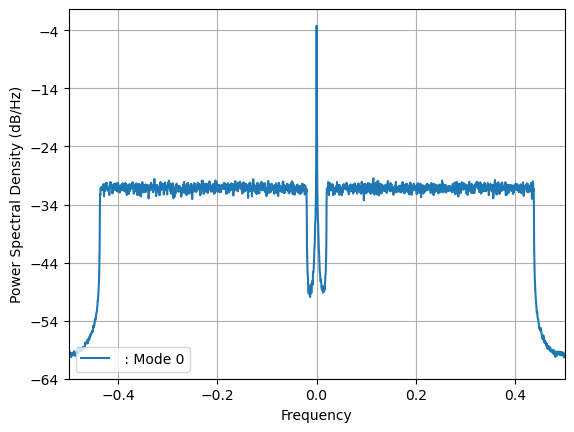

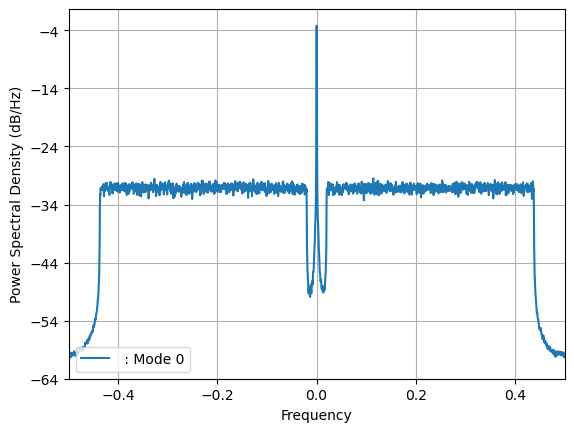

In [6]:
Rs  = 2.5e9         # symbol rate [baud]
SpS = 2           # samples per symbol

# transmitter parameters
Ts = 1 / Rs  # symbol period [s]
Fs = 1 / (Ts / SpS)  # sampling frequency [samples/s] --> 20 GSa/s
Fc = 193.1e12  # Hz

# Laser parameters
lw      = 100e3    # laser linewidth in Hz

# IQM parameters
Ai = 1
Vπ = 2
Vb = -Vπ

ϕ_pn_lo = phaseNoise(lw, len(OFDM_tx_slm), 1/Fs)
sigLa   = Ai*np.exp(1j*ϕ_pn_lo)

sigTxCh = iqm(sigLa, 0.5 * OFDM_tx_slm)



# Nmodes for Polarization Multiplex and indMode for 2 polarization
# launched power Pch in dB, Pch_dBm in dBm 

LaunchPower = 0 # power per WDM channel [dBm]
Nmodes = 1         # number of signal modes [2 for polarization multiplexed signals]

Pch = 10 ** (LaunchPower / 10) * 1e-3

sigTxCh = (
    np.sqrt(Pch / Nmodes)
    * pnorm(sigTxCh)
)

Pmode = 0
Pmode += signal_power(sigTxCh)
print("Pump Power (Input Power) = ", 10 * np.log10(Pmode / 1e-3) )

# SpectPlot(sigTxCh)
# MagniPlot(sigTxCh)
plotPSD(sigTxCh, Fs=1, Fc=0, NFFT=2048, fig=[], label=[])

################ Fiber Channel #################################################
# Fiber model
linearChannel = True

# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 800   # km
paramCh.Lspan  = 80    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.Fs = Fs  # Hz
paramCh.hz = 0.5       # km
paramCh.gamma = 1.3    # 1/(W.km)
paramCh.amp = 'ideal'
paramCh.prgsBar = False   # show progress bar?

if linearChannel:
    paramCh.hz = paramCh.Lspan  # km
    paramCh.gamma = 0   # 1/(W.km)

Fs = Rs*SpS
sigCh = ssfm(sigTxCh, paramCh) 

# sigCh = linFiberCh(sigTxCh, 800, 0.2, 16, 193.1e12, Fs)

print ("After Fiber Channel")
plotPSD(sigCh, Fs=1, Fc=0, NFFT=2048, fig=[], label=[])

**Receiver Section**

---



OSNR:  [38]
Obtained BER:  [0.47860048]


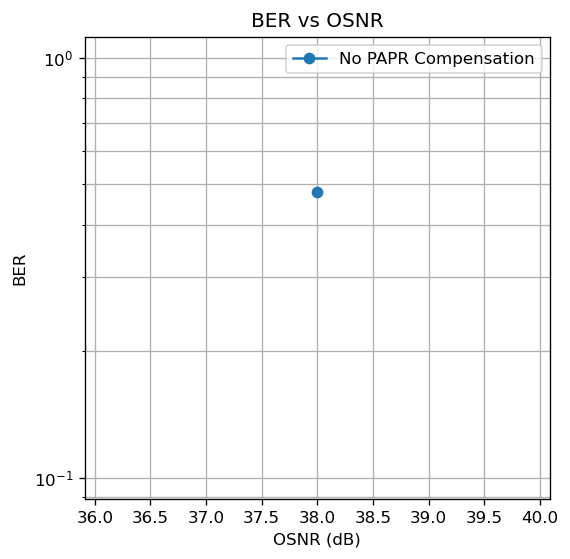

In [8]:
######################### Amplifier at the Receiver ############################
clip = False 
slm = False 
# osnr = [6, 10, 16, 20, 24, 28, 32, 36, 40, 44] # power per WDM channel [dBm]
osnr = [38]

paramEDFA = parameters()
# paramEDFA.G : amplifier gain in dB. The default is 20.
paramEDFA.NF = 3 # : EDFA noise figure in dB. The default is 4.5. --> noise figure 3
paramEDFA.Fc = Fc # : central optical frequency. The default is 193.1e12.
paramEDFA.Fs = 193.1e12 # : sampling frequency in samples/second.
sigCh_amp = edfa(sigCh, paramEDFA)


BER = []
for O in osnr:
    BER_per_ReceivePower = []
    for l in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:


        sigCh_snr = awgn(sigCh_amp, O, Fs, Rs)
        # sigCh_snr = sigCh
        # Pmode_rx = 0
        # Pmode_rx += signal_power(sigCh)
        # # print("Receive Power to the receiver = ", 10 * np.log10(Pmode_rx / 1e-3) )

        ######################### Coherent Receiver ####################################
        # photodiodes parameters
        paramPD = parameters()
        paramPD.B = Rs
        paramPD.Fs = Fs    
        paramPD.ideal = True

        # local oscillator (LO) parameters:
        #FO      = 150e6                # frequency offset
        lw      = 100e3                 # linewidth
        Plo_dBm = 10                    # power in dBm
        Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
        ϕ_lo    = 0                     # initial phase in rad 

        # generate LO field
        π       = np.pi
        t       = np.arange(0, len(sigCh))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)
        sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*t + ϕ_lo + ϕ_pn_lo))

        # Amplifier at input by 30 (TODO: implement an amplifier with noise figure)
        #OFDM_rx = sigTxCh * 2.5

        OFDM_rx = coherentReceiver(sigCh_snr, sigLO, paramPD)  # coherent detection


        ################## DSP block ##################################################
        QAM_rx_symbol = []
        CE_Symbol_add = np.zeros(855)
        # print ("number_of_OFDM_Symbols = ", number_of_OFDM_Symbols) # 114

        for i in range(number_of_OFDM_Symbols-2):

            # Extracting one OFDM symbol
            OFDM_rx_symbol = OFDM_rx[0+(K+CP)*i:(K+CP)+(K+CP)*i]
            if clip:
                OFDM_tx_symbol = OFDM_tx_clip[0+(K+CP)*i:(K+CP)+(K+CP)*i]
            elif slm:
                OFDM_tx_symbol = OFDM_tx_slm[0+(K+CP)*i:(K+CP)+(K+CP)*i]
            elif PAPRnet:
                OFDM_tx_symbol = OFDM_tx_NN[0+(K+CP)*i:(K+CP)+(K+CP)*i]
            else:
                OFDM_tx_symbol = OFDM_tx[0+(K+CP)*i:(K+CP)+(K+CP)*i]

            # removing CP 
            OFDM_RX_noCP = removeCP(OFDM_rx_symbol)
            OFDM_TX_noCP = removeCP(OFDM_tx_symbol)

            # converting to freq domain
            OFDM_freq = DFT(OFDM_RX_noCP)
            OFDM_freq_tx = DFT(OFDM_TX_noCP)

            # RF Pilot compensaion in time domain (idea combin RF pilot with FFT in one block (NN model))
            OFDM_freq_PNcomp = rfp(OFDM_freq, OFDM_RX_noCP)

            # Extract data payload (amplification here OFDM_demod_comp*30 might be better)
            # amplification is no more required CE is going to correct the amplitude and phase 
            QAM_rx_symbol_payload = OFDM_symbol_Rx(OFDM_freq_PNcomp)
            QAM_tx_symbol_payload = OFDM_symbol_Rx(OFDM_freq_tx)

            # CE and Correction
            if i < 4:
                # Estimation the Channel effect in frequency domain 4 training OFDM symbol is considered
                CE_Symbol = QAM_rx_symbol_payload/QAM_tx_symbol_payload
                CE_Symbol_add = CE_Symbol_add + CE_Symbol
            if i == 3:
                CE_Symbol_avg = CE_Symbol_add/4
            if i > 3:
                # CE compemstaion
                OFDM_freq_PNcomp_ce=QAM_rx_symbol_payload/CE_Symbol_avg
                #OFDM_freq_PNcomp_ce=QAM_rx_symbol_payload*np.exp(-1j*CE_Symbol_avg)

                if slm:
                    phaseVec_payload = OFDM_symbol_Rx(SLMPhaseVectors[i])
                    unmappedSymbols = np.multiply(OFDM_freq_PNcomp_ce, np.conj(phaseVec_payload))
                else:
                    unmappedSymbols = OFDM_freq_PNcomp_ce
                    
                QAM_rx_symbol = np.append(QAM_rx_symbol, unmappedSymbols)
                

        if PAPRnet:
            # NN decoding 
            QAM_rx_symbol_input = QAM_rx_symbol.reshape((-1,855))

            # splitting real and imaginary comp
            QAM_rx_symbol_input_Rect = np.concatenate( [np.expand_dims(QAM_rx_symbol_input.real, 1),np.expand_dims(QAM_rx_symbol_input.imag, 1)], axis=1)

            # getting dncoder output
            QAM_rx_symbol_NN_Rec = decoder.predict(QAM_rx_symbol_input_Rect, batch_size=855)   

            # converting to complex value (a+bj)
            QAM_rx_NN = QAM_rx_symbol_NN_Rec[:, 0, :] + 1j * QAM_rx_symbol_NN_Rec[:, 1, :]


            # Flat the lists
            OFDM_tx_NN_symbol = QAM_rx_NN.reshape(-1)

            # bit decision
            PS_est, hardDecision = Demapping(OFDM_tx_NN_symbol)
        else:
            PS_est, hardDecision = Demapping(QAM_rx_symbol)
        
        # prepare the bit stream
        bits_est = PS(PS_est)

        # Constelation Plot 
#         plt.plot(QAM_rx_symbol.real, QAM_rx_symbol.imag, 'bo')
        obtained_ber = np.sum(abs(bits_used[payloadBits_per_OFDM*4:]-bits_est))/len(bits_used[payloadBits_per_OFDM*4:])
#         print ("Obtained Bit error rate: ", obtained_ber)
        BER_per_ReceivePower = np.append(BER_per_ReceivePower, obtained_ber)
        if l == 10:
            BER_mean = sum(BER_per_ReceivePower)/len(BER_per_ReceivePower)
            BER = np.append(BER, BER_mean)




# calculating Q factor 
# qFactor= np.sqrt(2)*special.erfcinv(BER/0.5)


# printing results 
print ("OSNR: ", osnr)
print ("Obtained BER: ", BER)
# print ("Obtained Q Factor per Recieved Power: ", 20*np.log10(qFactor))


# # ploting 
fig = plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k');
plt.plot(osnr, BER, '-o')
plt.semilogy();
plt.title('BER vs OSNR');
plt.xlabel('OSNR (dB)');
plt.ylabel('BER');
plt.legend(['No PAPR Compensation']);
plt.grid(True, which="both", ls="-")
plt.show()